# iNeRF

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import sys
import os
import copy

ROOT_DIR = os.getcwd()
sys.path.insert(0, os.path.join(ROOT_DIR, ".."))
sys.path.insert(0, os.path.join(ROOT_DIR, "src"))
sys.path.insert(0, os.path.join(ROOT_DIR, "inerf_utils"))

import json
import torch
import numpy as np
import torchvision.transforms as T
import tqdm
import imageio
import cv2
import matplotlib.pyplot as plt
import wisp
from wisp.core import RenderBuffer, Rays

from scipy.spatial.transform import Rotation as R

In [4]:
sys.argv[1:] = [
    '--config=../app/nerf/configs/nerf_hash.yaml',
    '--pretrained=/home/saptarshi/dev/kaolin-wisp/_results/logs/runs/cheezit_all_nobg_sam_s10/20230508-134127/model.pth',
    '--dataset-path=/home/saptarshi/dev/nerf-pytorch/sim_data/processed/cheezit_all_nobg_sam/',
    '--valid-only'
]

In [5]:
sys.argv

['/home/saptarshi/miniconda3/envs/wisp2/lib/python3.9/site-packages/ipykernel_launcher.py',
 '--config=../app/nerf/configs/nerf_hash.yaml',
 '--pretrained=/home/saptarshi/dev/kaolin-wisp/_results/logs/runs/cheezit_all_nobg_sam_s10/20230508-134127/model.pth',
 '--dataset-path=/home/saptarshi/dev/nerf-pytorch/sim_data/processed/cheezit_all_nobg_sam/',
 '--valid-only']

In [6]:
config = {
    'input': '../input/rgb_0010.png',
    'target': '../input/rgb_0028.png',
    'output': './pose_estimation'
}

In [7]:
W, H = 100, 100

input_image_np = cv2.resize(cv2.imread(config['input'], cv2.IMREAD_UNCHANGED), (W, H), interpolation=cv2.INTER_AREA)
target_image_np = cv2.resize(cv2.imread(config['target'], cv2.IMREAD_UNCHANGED), (W, H), interpolation=cv2.INTER_AREA)

input_image_np = cv2.cvtColor(input_image_np, cv2.COLOR_BGRA2RGBA)
target_image_np = cv2.cvtColor(target_image_np, cv2.COLOR_BGRA2RGBA)

In [8]:
fx = (0.5 * H) / np.tan(0.5 * float(1.3213687585295282))
extra_args = {
  'resume' : True,
  'output' : './pose_estimation',
  'device' : 'cuda',
  'z_near' : 0.0,
  'z_far' : 10.0,
  'focal' : fx,
  'lrate' : 1e-3,
}

In [9]:
def convert_to_mat_internal(params) -> torch.Tensor:
    batch_size = params.shape[0]
    a1 = params[:, 0:3]
    a2 = params[:, 3:6]
    translation = params[:, 6:9]

    b1 = torch.nn.functional.normalize(a1, dim=1)
    b1_dot_a2 = torch.bmm(b1.view(-1, 1, 3), a2.view(-1, 3, 1)).view(batch_size, 1)    # Batched dot product
    b2 = torch.nn.functional.normalize(a2 - b1_dot_a2 * b1, dim=1)
    b3 = torch.cross(b1, b2)

    rotation = torch.stack([b1, b2, b3], dim=1)  # Stack row-wise
    extrinsics_mat = torch.cat([rotation, translation.unsqueeze(-1)], dim=2)  # Stack column-wise
    homogeneous_row = translation.new_tensor([[0.0, 0.0, 0.0, 1.0]]).unsqueeze(0).expand(batch_size, 1, 4)
    mat = torch.cat([extrinsics_mat, homogeneous_row], dim=1)
    return mat


In [10]:
from wisp.framework import WispState
from inerf_utils import *
from kaolin.render.camera import Camera, PinholeIntrinsics, CameraExtrinsics, CameraIntrinsics, blender_coords
from kaolin.render.camera.extrinsics_backends import _Matrix6DofRotationRep

from wisp.ops.raygen import generate_pinhole_rays, generate_centered_pixel_coords
from wisp.datasets import SampleRays
from wisp.trainers import MultiviewTrainer
from wisp.models.pipeline import Pipeline

from scipy.optimize import minimize
from scipy.optimize import differential_evolution as de
from scipy.linalg import expm
from scipy.linalg import logm

import plotly.express as px

def make_model(args, args_dict, extra_args, train_dataset, validation_dataset):
    pipeline = torch.load(args.pretrained)
    pipeline.to(extra_args['device'])
    scene_state = WispState()
    trainer = load_trainer(
        pipeline=pipeline,
        train_dataset=train_dataset, 
        validation_dataset=validation_dataset,
        device=extra_args['device'], 
        scene_state=scene_state,
        args=args, 
        args_dict=args_dict
    )
    return trainer, pipeline
    # return pipeline

def gen_camera(pose, focal, w, h, far):
# def gen_camera(params_6d, focal, w, h, far):
    # view_matrix = pose
    # view_matrix = torch.zeros_like(pose)
    # view_matrix[:3, :3] = pose[:3, :3].T
    # view_matrix[:3, -1] = torch.matmul(-view_matrix[:3, :3], pose[:3, -1])
    # view_matrix[3, 3] = 1.0
    view_matrix = torch.linalg.inv(pose)

    x0 = 0.0
    y0 = 0.0

    camera = Camera.from_args(
        view_matrix=view_matrix,
        focal_x=focal,
        focal_y=focal,
        width=w,
        height=h,
        far=far,
        near=0.0,
        x0=x0,
        y0=y0,
        dtype=torch.float32,
        device=extra_args['device']
    )

    camera.change_coordinate_system(blender_coords())

    return camera

def gen_rays_only(camera):
    ray_grid = generate_centered_pixel_coords(camera.width, camera.height, camera.width, camera.height, device=extra_args['device'])
    rays = generate_pinhole_rays(camera, ray_grid).reshape(camera.height, camera.width, 3)
    rays = Rays.stack(rays)
    return rays

In [11]:
args, args_dict = parse_args()
train_dataset, validation_dataset = load_dataset(args=args)

['val', 'train', 'transforms_train.json', 'transforms_test.json', 'transforms_val.json']
<class 'wisp.datasets.formats.rtmv_dataset.RTMVDataset'>
False
<class 'wisp.datasets.formats.nerf_standard_dataset.NeRFSyntheticDataset'>
True


loading data:   0%|          | 0/80 [00:00<?, ?it/s]

loading data: 100%|██████████| 80/80 [00:01<00:00, 66.89it/s]


128.66666158040366


/home/saptarshi/miniconda3/envs/wisp2/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
loading data: 100%|██████████| 20/20 [00:00<00:00, 67.14it/s]


128.66666158040366


In [12]:
os.makedirs(extra_args['output'], exist_ok=True)

z_near, z_far = extra_args['z_near'], extra_args['z_far']
# in_sz = extra_args['size']

# sz = list(map(int, extra_args['out_size'].split()))
# if len(sz) == 1:
#     H = W = sz[0]
# else:
#     assert len(sz) == 2
#     W, H = sz

model, pipeline = make_model(
    args, args_dict, extra_args, train_dataset, validation_dataset)
# pipeline = make_model(args, args_dict, extra_args, None, None)

# image_to_tensor = get_image_to_tensor_balanced()

# Encoding the input image.
print(f"Input image: {config['input']}")
# input_image = Image.fromarray(input_image_np)
# input_image = T.Resize(in_sz)(input_image)
# input_image = image_to_tensor(input_image).to(device=extra_args['device'])
# input_pose = torch.eye(4)

input_pose = torch.asarray([
    [
        0.42720182489278596,
        -0.10484522338339419,
        0.8980568355855656,
        0.30430070362714434
    ],
    [
        0.9041562922461321,
        0.04953797384897814,
        -0.4243199127293752,
        -0.1437780411814363
    ],
    [
        1.370934642397517e-16,
        0.993253979745676,
        0.11595918126382164,
        0.00546401181456807
    ],
    [
        0.0,
        0.0,
        0.0,
        0.9999999999999998
    ]
])

target_pose = torch.tensor([
    [
        0.6942095742701236,
        0.1056400694515154,
        -0.7119784004574662,
        -0.2773861835496738
    ],
    [
        -0.7197729273817498,
        0.1018881717412901,
        -0.6866918766575909,
        -0.2675346107086036
    ],
    [
        1.9761370330591742e-17,
        0.9891708528790649,
        0.1467686063656108,
        0.02335292494619058
    ],
    [
        0.0,
        0.0,
        0.0,
        1.0
    ]
])

input_pose[..., :3, 3] *= 10/1.25
target_pose[..., :3, 3] *= 10/1.25

# input_pose = torch.linalg.inv(input_pose)
# target_pose = torch.linalg.inv(target_pose)


print(f"Target image: {config['target']}")
# target_image = Image.fromarray(target_image_np)
# target_image = T.Resize(in_sz)(target_image)
target_image_flatten = np.reshape(target_image_np, [-1, 4]) / 255.0
target_image_flatten = torch.from_numpy(
    target_image_flatten).float().to(device=extra_args['device'])


Input image: ../input/rgb_0010.png
Target image: ../input/rgb_0028.png


In [13]:
# cam = gen_camera(input_pose.detach(), extra_args['focal'], W, H, z_far)
# cam = gen_camera(target_pose.detach(), extra_args['focal'], W, H, z_far)

# cam = gen_camera(input_pose.detach(), 500, W, H, z_far)
def get_image(cam):
    cam = copy.deepcopy(cam)

    rays = gen_rays_only(cam)
    rays = rays.reshape((rays.shape[0]**2, -1))

    rb = model.renderer.render(pipeline, rays, lod_idx=None)
    rgb = rb.rgb.detach().cpu().numpy().reshape((H, W, 3))
    # alpha = rb.alpha.detach().cpu().numpy().reshape((H, W, 1))
    # v = np.concatenate([rgb, alpha], axis=2)

    # return v
    # return rgb, alpha
    return rgb

In [14]:
def render_pipeline(renderer, pipeline, rays, lod_idx):
    rb = RenderBuffer(xyz=None, hit=None, normal=None, shadow=None, ao=None, dirs=None)
    for ray_pack in rays.split(renderer.render_batch):
        rb  += pipeline.tracer(pipeline.nef, rays=ray_pack, lod_idx=lod_idx, **renderer.kwargs)
    return rb

In [15]:
curr_pose = torch.clone(target_pose).detach().unsqueeze(0)
# curr_pose[1,3] += 1
camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
print(camera.extrinsics.parameters()[0,6:9])

tensor([-0.1019,  0.2677, -0.7120], device='cuda:0')


In [16]:
0.05-0.1019

-0.0519

In [17]:
# cam_pose = torch.clone(input_pose.detach())
# cam_pose.requires_grad = True

# Create optimizer.
n_steps = 0

# Pose optimization.
predicted_poses = []
fine_patches = []
gt_patches = []

# x = torch.tensor([0.1], requires_grad=True)
# x = torch.autograd.Variable(torch.tensor(0.1))

curr_pose = torch.clone(target_pose).detach()
# curr_pose.requires_grad = True

# params = _Matrix6DofRotationRep.convert_from_mat(torch.linalg.inv(torch.clone(target_pose).detach().unsqueeze(0)))
# rep = _Matrix6DofRotationRep(params)

# params = params + x
# params.requires_grad = True
# camera = gen_camera(params, extra_args['focal'], W, H, z_far)

camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
camera.switch_backend('matrix_6dof_rotation')

# camera.rotate(*np.random.uniform(-0.02, 0.02, (3,)).tolist())
# camera.translate(torch.tensor(np.random.uniform(-0.05, 0.05, (3,)), device='cuda', dtype=torch.float32))

# plt.imshow(get_image(camera))
# plt.show()

camera.extrinsics._backend.params[0,6] += 0.2
camera.extrinsics.requires_grad = True

optimizer = torch.optim.Adam(params=[camera.extrinsics.parameters()], lr=0.1)


target_mask = (target_image_flatten[...,3] > 0.001)
# idxs_sampled = torch.where(target_mask)
prev_loss = np.inf

for i_step in range(n_steps):
    optimizer.zero_grad()
    n_samples = 50

    for i in range(n_samples):
        rays = gen_rays_only(camera)
        rays = rays.reshape((rays.shape[0]**2, -1))

        rb = pipeline(rays)
        # rb = render_pipeline(model.renderer, pipeline, rays, None)
        # rb = model.renderer.render(pipeline, rays, lod_idx=None)
        loss = torch.abs(rb.rgb - target_image_flatten[:,:3]).mean()
        loss.backward()

    # print(f"Step {i_step}, loss: {loss}")
        # predicted_poses.append(torch.clone(cam_pose).detach().numpy())
        # fine_patches.append(torch.clone(rgb).detach().cpu().numpy().reshape(H, W, 3))
        # gt_patches.append(torch.clone(target_image_flatten).detach().cpu().numpy().reshape(H, W, 3))
        
    mask = torch.zeros_like(camera.extrinsics.parameters())
    mask[0, 6] = 1
    camera.extrinsics.parameters().grad *= mask
    print(f'{i_step}, loss: {loss.item()}, x : {camera.extrinsics.parameters()[0,6].item()}, grad : {camera.extrinsics.parameters().grad[0,6].item()}')
    # break
    optimizer.step()
    # print(f"Step {i_step}, loss: {loss}, {cam_pose.grad}")

# plt.imshow(get_image(camera))
# plt.show()

In [18]:
# camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
# camera.switch_backend('matrix_6dof_rotation')
# print(camera.extrinsics.parameters()[0,6])
# camera.extrinsics._backend.params[0,6] += 0.2
# print(camera.extrinsics.parameters())


In [19]:
def get_euler_pose(rot_pose):
  # curr_pose = torch.clone(rot_pose).detach()
  # camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
  best_params_se3 = rot_pose.reshape((4,4)).detach().cpu().numpy()
  best_params_euler = np.concatenate([R.from_matrix(best_params_se3[:3, :3]).as_euler('zxz', degrees=True), best_params_se3[:3, -1]])
  return best_params_euler

def get_rot_pose(euler_pose):
  r = R.from_euler('zxz', euler_pose[:3], degrees=True)
  t = euler_pose[3:]
  pose = np.eye(4)
  pose[:3,:3] = r.as_matrix()
  pose[:3, -1] = t
  return pose

In [20]:
def get_se3_pose(pose_6d):
    a,b,c = pose_6d[3:]
    skm = np.array([[0,a,b], [-a,0,c], [-b,-c,0]])
    rot = expm(skm)
    se3_pose = np.eye(4)
    se3_pose[:3,:3] = rot
    se3_pose[:3,-1] = pose_6d[:3]
    return se3_pose

def get_pose_6d(se3_pose):
    rot = se3_pose[:3,:3]
    skm = logm(rot)
    pose_6d = np.zeros(6)
    pose_6d[:3] = se3_pose[:3,-1]
    pose_6d[3:] = np.array((skm[0,1], skm[0,2], skm[1,2]))
    return pose_6d

In [21]:
# v = torch.random.get_rng_state()

def lossfn2(p, get_grad=False, rewrite=False, opt_all=False, resample=False):
    curr_pose = torch.clone(target_pose).detach()
    camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
    # print(camera.extrinsics._backend.params)
    # print(p)
    camera.extrinsics._backend.params = torch.tensor(p, device='cuda', dtype=torch.float32)
    # camera.switch_backend('matrix_6dof_rotation')
    # print(type(x))
    # print(camera.extrinsics._backend.params[0,6:])
    # if opt_all:
    #     camera.extrinsics._backend.params = torch.tensor(p, device='cuda')
    # elif rewrite:
    #     camera.extrinsics._backend.params[0,6:] = torch.tensor(p, device='cuda')
    # else:
    #     camera.extrinsics._backend.params[0,6:] += torch.tensor(p, device='cuda')
    
    # print(camera.extrinsics.parameters().dtype)
    # print(camera.intrinsics.parameters().dtype)

    if get_grad:
        camera.extrinsics.requires_grad = True

    # camera.extrinsics._backend.params[0,6:] = torch.tensor(p, device='cuda')
    # camera.extrinsics._backend.params[0] = torch.tensor(p, device='cuda')

    # camera.extrinsics._backend.params[0] = torch.tensor(p, device='cuda')

    # camera.extrinsics._backend.params[0,6:] += torch.tensor((x,y,z), device='cuda')
    # camera.extrinsics._backend.params[0,6:] = torch.tensor((x,y,z), device='cuda')

    if resample:
        total_loss = 0
        num_samples = 50
        for i in range(num_samples):
            rays = gen_rays_only(camera)
            rays = rays.reshape((rays.shape[0]**2, -1))
            rb = pipeline(rays)
            loss = torch.square(rb.rgb - target_image_flatten[:,:3]).mean()
            total_loss += loss
            if get_grad:
                loss.backward()
        loss = total_loss / num_samples
    else:
        rays = gen_rays_only(camera)
        rays = rays.reshape((rays.shape[0]**2, -1))
        # torch.random.set_rng_state(v)
        rb = pipeline(rays)
        loss = torch.abs(rb.rgb - target_image_flatten[:,:3]).mean()
        if get_grad:
            loss.backward()

    # plt.imshow(rb.rgb.reshape((200,200,3)).detach().cpu().numpy())
    # plt.show()
    # print(loss)
    # print(camera.extrinsics._backend.params.grad)
    if get_grad:
        return loss.item(), camera.extrinsics._backend.params.grad[0, 6].detach().cpu().numpy()
    return loss.item()

    # print(loss)
    # mask = torch.zeros_like(camera.extrinsics.parameters())
    # mask[0,7] = 1
    # camera.extrinsics.parameters().grad *= mask

def cvt_pose(pose):
    curr_pose = torch.clone(target_pose).detach()
    camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
    # camera.switch_backend('matrix_6dof_rotation')
    return camera.extrinsics._backend.params

def cvt_pose_se3(pose):
    pose = torch.clone(pose).detach()
    camera = gen_camera(pose, extra_args['focal'], W, H, z_far)
    pose = camera.extrinsics._backend.params.cpu().numpy().reshape((4,4))
    return pose

def get_scipy_image(t):
    camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
    # camera.switch_backend('matrix_6dof_rotation')
    camera.extrinsics._backend.params = torch.tensor(t, device='cuda', dtype=torch.float32)
    print(camera.extrinsics.parameters().dtype, camera.intrinsics.parameters().dtype)
    im = get_image(camera)
    return (255*im).astype(np.uint8) 

def grad(x,y,z):
    h = 1e-4
    gx = (lossfn2((x+h, y, z)) - lossfn2((x,y,z))) / h
    return gx

def lossfn_scipy(p):
    return lossfn2(p, rewrite=True)

def lossfn_euler(p):
    pose = get_rot_pose(p)
    return lossfn2(pose.flatten())

def lossfn_combined_scipy(p):
    se3_pose = get_se3_pose(p)
    return lossfn2(se3_pose, rewrite=True, opt_all=True)

In [22]:
# lossfn_scipy(cvt_pose(target_pose)[0, 6:].detach().cpu().numpy())
# best_t = cvt_pose(target_pose)[0, 6:].detach().cpu().numpy()
# del_x = np.random.normal(size=(3), scale=0.5)

In [45]:
pose = cvt_pose_se3(target_pose)
best_pose_6d = get_pose_6d(pose)
new_pose_6d = best_pose_6d.copy()
# new_pose_6d += np.random.normal(np.zeros(6), scale=0.1)
# new_pose_6d[3:] += np.random.normal(np.zeros(3), scale=0.5)
# new_pose_6d[:3] += np.random.normal(np.zeros(3), scale=0.1)

logm result may be inaccurate, approximate err = 2.934046307829184e-07


/tmp/ipykernel_1963989/3397254522.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  pose_6d[3:] = np.array((skm[0,1], skm[0,2], skm[1,2]))


In [24]:
# pose = cvt_pose_se3(input_pose)
# new_pose_6d = get_pose_6d(pose)

In [25]:
# im_start = get_scipy_image(get_se3_pose(new_pose_6d))
# im_target = get_scipy_image(get_se3_pose(best_pose_6d))

# sift = cv2.SIFT_create()

# # Detect and compute keypoints and descriptors
# keypoints1, descriptors1 = sift.detectAndCompute(cv2.cvtColor(im_start, cv2.COLOR_RGB2GRAY), None)
# keypoints2, descriptors2 = sift.detectAndCompute(cv2.cvtColor(im_target, cv2.COLOR_RGB2GRAY), None)

# # FLANN parameters
# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
# search_params = dict(checks=50)

# # Create FLANN matcher
# flann = cv2.FlannBasedMatcher(index_params, search_params)

# # Match descriptors
# matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# # Apply ratio test
# good_matches = []
# for m, n in matches:
#     if m.distance < 0.75 * n.distance:
#         good_matches.append(m)

# # Draw matches
# matched_image = cv2.drawMatches(im_start, keypoints1, im_target, keypoints2, good_matches, None)
# plt.imshow(matched_image)

In [26]:
print(best_pose_6d)
print(new_pose_6d)

[-1.15872176e-07  2.67693430e-01 -3.07707453e+00 -5.91738963e-02
  8.01989668e-01 -1.39284072e-01]
[-1.15872176e-07  2.67693430e-01 -3.07707453e+00 -5.91738963e-02
  8.01989668e-01 -1.39284072e-01]


In [27]:
lossfn_combined_scipy(best_pose_6d), lossfn_combined_scipy(new_pose_6d)

(0.0076494100503623486, 0.007755897473543882)

In [28]:
np.linalg.norm(best_pose_6d - new_pose_6d), np.linalg.norm(best_pose_6d - get_pose_6d(cvt_pose_se3(input_pose)))

logm result may be inaccurate, approximate err = 1.9465848546281267e-07


/tmp/ipykernel_1963989/3397254522.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  pose_6d[3:] = np.array((skm[0,1], skm[0,2], skm[1,2]))


(0.0, 1.9748827242998146)

In [44]:
new_pose_6d

array([-1.15872176e-07,  2.67693430e-01, -3.07707453e+00, -5.91738963e-02,
        8.01989668e-01, -1.39284072e-01])

Loss at initial point 0.007727615535259247
iter 0, loss 0.007458734326064587
torch.float32 torch.float32
torch.float32 torch.float32
torch.float32 torch.float32


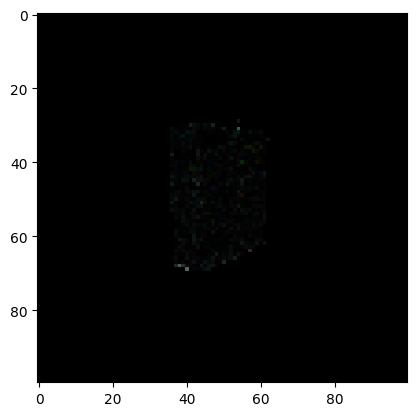

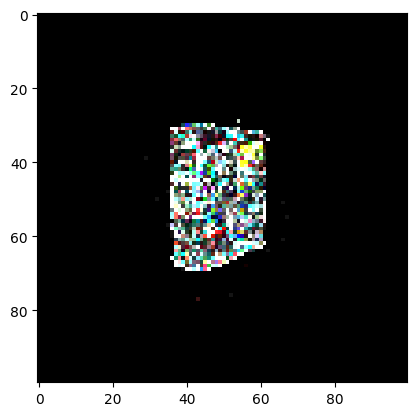

In [46]:
tol = 1e-4
iter = 0
x0 = new_pose_6d
prev_loss = np.inf
print(f'Loss at initial point {lossfn_combined_scipy(new_pose_6d)}')
while True:
    val = minimize(
        fun = lossfn_combined_scipy,
        x0 = new_pose_6d,
        method='COBYLA', 
    )
    print(f'iter {iter}, loss {val.fun}')
    if iter > 5 and (abs(prev_loss - val.fun) < tol):
        break
    x0 = val.x
    prev_loss = val.fun

    im_start = get_scipy_image(get_se3_pose(new_pose_6d))
    im_target = get_scipy_image(get_se3_pose(best_pose_6d))
    im_end = get_scipy_image(get_se3_pose(val.x))

    start_diff = cv2.absdiff(im_start, im_target)
    end_diff = cv2.absdiff(im_end, im_target)

    plt.imshow(start_diff)
    plt.show()
    plt.imshow(cv2.convertScaleAbs(end_diff, 1, 20))
    plt.show()

    iter += 1
    break

In [30]:
val

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.007600836455821991
       x: [ 2.353e-04  2.688e-01 -3.076e+00 -5.824e-02  8.025e-01
           -1.469e-01]
    nfev: 52
   maxcv: 0.0

torch.float32 torch.float32


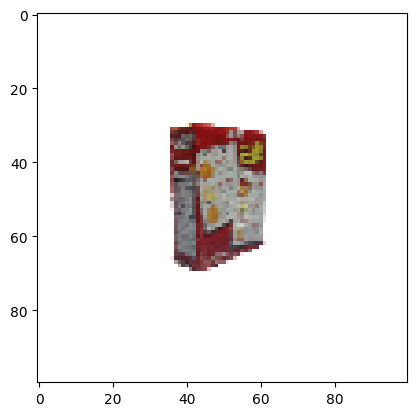

In [41]:
plt.imshow(get_scipy_image(cvt_pose(target_pose).detach().cpu().numpy()))

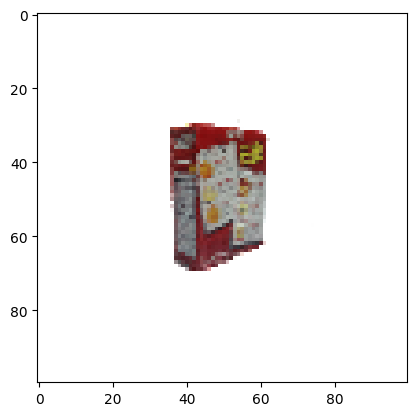

In [34]:
plt.imshow(get_image(gen_camera(target_pose, extra_args['focal'], W, H, z_far)))

In [31]:
im_start = get_scipy_image(get_se3_pose(new_pose_6d))
im_target = get_scipy_image(get_se3_pose(best_pose_6d))
im_end = get_scipy_image(get_se3_pose(val.x))

start_diff = cv2.absdiff(im_start, im_target)
end_diff = cv2.absdiff(im_end, im_target)

torch.float32 torch.float32
torch.float32 torch.float32
torch.float32 torch.float32


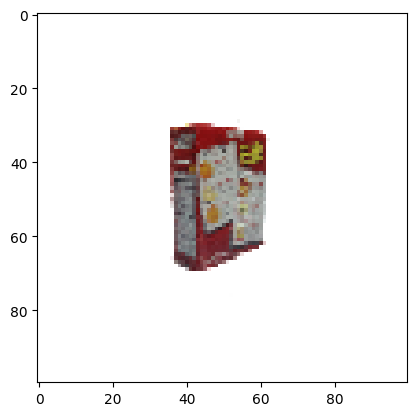

In [32]:
plt.imshow(im_start)

In [371]:
best_pose_6d, val.x

(array([-1.15872176e-07,  2.67693430e-01, -3.07707453e+00, -5.91738963e-02,
         8.01989668e-01, -1.39284072e-01]),
 array([-0.02420327,  0.22860855, -3.05016805, -0.0395239 ,  0.90551222,
        -0.030305  ]))

In [ ]:
# plt.imshow(im_start)
# plt.show()
# plt.imshow(im_target)
# plt.show()
# plt.imshow(im_end)

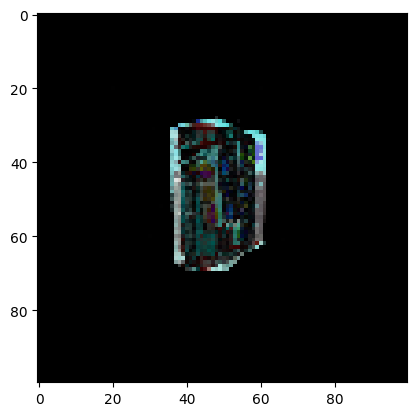

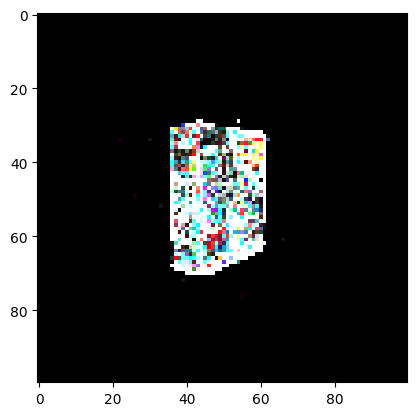

In [373]:
plt.imshow(start_diff)
plt.show()
plt.imshow(cv2.convertScaleAbs(end_diff, 1, 20))
plt.show()

In [ ]:
lossfn_scipy(best_t)

0.006931275594979525

In [ ]:
# de(lossfn_euler, [(-180, 180), (0,180), (-180, 180)] + [(-4,4)]*3)
# val = minimize(lossfn_euler, get_euler_pose(input_pose), method='Nelder-Mead')

In [ ]:
# im = get_image(gen_camera(torch.tensor(get_rot_pose(best_t)), extra_args['focal'], W, H, z_far))
# im = get_image(gen_camera(torch.tensor(input_pose), extra_args['focal'], W, H, z_far))
# plt.imshow(im)

In [ ]:
# import pyceres
# # pyceres.

In [ ]:
lossfn2((0,0,0), rewrite=False)

0.006910568103194237

In [ ]:
# xval = np.linspace(-0.5,0.5,5000)
xval = np.linspace(-0.1,0.1,10)
y = np.array([lossfn2((x,0,0), get_grad=True) for x in xval])
yval = y[:, 0]
ygrad = y[:, 1]
# ygrad_numerical = np.array([grad(x,0,0) for x in xval])

In [ ]:
fig = px.line(x=xval, y=yval)
fig.write_html('y_val.html')
fig

In [ ]:
fig = px.line(x=xval, y=ygrad)
fig

In [ ]:
fig = px.line(x=xval, y=ygrad_numerical)
fig

In [ ]:
fig = px.line(x=xval, y=ygrad_numerical)
fig

In [ ]:
fig = px.line(x=xval, y=ygrad)
fig

In [ ]:
def normalize(vec):
  return vec / np.linalg.norm(vec)

def rep2mat(rep):
  a1 = rep[0:3]
  a2 = rep[3:6]
  translation = rep[6:9]

  b1 = normalize(a1)
  b1_dot_a2 = np.dot(b1, a2)    # Batched dot product
  b2 = normalize(a2 - b1_dot_a2 * b1)
  b3 = np.cross(b1, b2)

  rotation = np.stack([b1, b2, b3], axis=0)  # Stack row-wise
  final_mat = np.eye(4)
  final_mat[:3, :3] = rotation
  final_mat[:3,3] = translation
  return final_mat

def mat2rep(mat):
  rotation = mat[:2, :3]
  translation = mat[:3, -1:]
  params = np.vstack([rotation, translation.T])
  return params


In [ ]:
def lossfn(pose_6dof):
    pose_6dof = pose_6dof.reshape(-1)
    with torch.no_grad():
        pose = rep2mat(pose_6dof)
        camera = gen_camera(torch.tensor(pose), extra_args['focal'], W, H, z_far)
        # camera.switch_backend('matrix_6dof_rotation')
        # print(target_pose_np)
        # print(camera.extrinsics.parameters())
        rays = gen_rays_only(camera)
        rays = rays.reshape((rays.shape[0]**2, -1))
        rb = render_pipeline(model.renderer, pipeline, rays, None)
        loss = torch.abs(rb.rgb - target_image_flatten[:,:3]).mean().item()
        return loss

def bayes_fn(x0, x1, x2, x3, x4, x5, x6, x7, x8):
    pose = np.array([x0, x1, x2, x3, x4, x5, x6, x7, x8])
    return -lossfn(pose)

def fitness_fn(ga, sol, id):
    return lossfn(sol)

input_pose_np = input_pose.detach().numpy()
target_pose_np = target_pose.detach().numpy()


In [ ]:
from scipy.optimize import minimize
from scipy.spatial.transform import Rotation as R

def zloss(z):
    pose = target_pose_np.copy()
    # r = R.from_euler('x', z, degrees=True)
    # print(r.as_matrix())
    # pose[:3, :3] = np.matmul(pose[:3,:3], r.as_matrix())
    pose[0,3] += z
    
    # pose[1,-1] += z
    # pose[2,-1] += z

    # print(pose[-1,2])
    # print(pose)
    # print(mat2rep(pose))
    return lossfn(mat2rep(pose)) 

# print(zloss(1))
# minimize(zloss, 0.1)
xval = np.linspace(-10,10,200)
yval = np.array([zloss(x) for x in xval])
plt.plot(xval, yval)

# lossfn(mat2rep(input_pose_np))

In [ ]:
minimize(zloss, -1, method='L-BFGS-B', bounds=((-2,2),))

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.0611208900809288
        x: [-1.000e+00]
      nit: 3
      jac: [ 7.126e+02]
     nfev: 64
     njev: 32
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [ ]:
import pygad

num_parameters = 9
sol_per_pop = 100

ga_instance = pygad.GA(
    num_generations=10, 
    num_parents_mating=5, 
    fitness_func=fitness_fn,
    sol_per_pop=sol_per_pop,
    num_genes=num_parameters,
    # init_range_low=-10,
    # init_range_high=10
)

ga_instance.run()
best_solution = ga_instance.best_solution()
best_fitness = best_solution[1]


In [ ]:
from bayes_opt import BayesianOptimization

param_ranges = [(0, 10)] * 9
params = {"x" + str(i): param_ranges[i] for i in range(9)}
opt = BayesianOptimization(bayes_fn, params)

opt.maximize(init_points=100, n_iter=500)

In [ ]:
best_fitness

0.7737385630607605

In [ ]:
best_solution

(array([ 0.35237381,  0.894491  ,  2.4086116 ,  2.20641276, -0.06935649,
        -2.25619489, -0.1873843 ,  0.21882803, -0.94564072]),
 0.8691818714141846,
 0)

In [ ]:
camera = gen_camera(torch.clone(input_pose).detach(), extra_args['focal'], W, H, z_far)
# camera.extrinsics.parameters().reshape((4,4))

In [ ]:
camera.switch_backend('matrix_6dof_rotation')
# camera.extrinsics.parameters().reshape((3,3))
camera.extrinsics.requires_grad = True

In [ ]:
camera.extrinsics.parameters().grad

In [ ]:
rays = gen_rays_only(camera)

In [ ]:
v = (rays[0][0].origins).mean()

In [ ]:
v.backward()

In [ ]:
camera.extrinsics.parameters().grad

tensor([[ 1.0570, -0.0779, -0.9993,  0.7390, -0.1509, -0.6985, -0.4717, -0.3310,
         -0.0358]], device='cuda:0')

In [ ]:
rays.shape

torch.Size([200, 200])

In [ ]:
# rays.origins.mean(dim=(0,1)) - rays[0,0].origins
# (rays[199,199].origins[0] - rays[0,0].origins[0])

# torch.std(rays.origins, dim=(0,1))



tensor([0., 0., 0.], device='cuda:0', grad_fn=<StdBackward0>)

In [ ]:
# d = torch.tensor([[1.,0,0]], requires_grad=True)
# new_rays = Rays(
#     origins=torch.clone(rays[0,0].origins[:,None]), 
#     dirs=torch.clone(rays[0,0].origins[:,None])
# ).to('cuda')
ray = rays[50:51, 105, :]
og = ray.origins.detach()
# og.requires_grad = True
dr = ray.dirs.detach()
# dr.requires_grad = True

new_rays = Rays(origins=og, dirs=dr, dist_max=6.)

In [ ]:
# rb = pipeline.tracer(pipeline.nef, rays=new_rays, lod_idx=None)
rb = pipeline(new_rays)

In [ ]:
v = rb.rgb.mean()

In [ ]:
v.backward()

In [ ]:
rb

Renderbuffer_1(rgb=tensor([[0.7956, 0.5459, 0.4993]], device='cuda:0',
       grad_fn=<IndexPutBackward0>), alpha=tensor([[0.8601]], device='cuda:0', grad_fn=<IndexPutBackward0>), depth=tensor([[1.8205]], device='cuda:0', grad_fn=<CopySlices>), epistemic=tensor([[2.2154]], device='cuda:0', grad_fn=<IndexPutBackward0>), hit=tensor([True], device='cuda:0'))

In [ ]:
dr.grad

tensor([[-0.0137,  0.0810,  0.0454]], device='cuda:0')

In [ ]:
og.grad

In [ ]:
g = pipeline(rays.reshape((200*200, -1))).reshape((200, 200, -1)).rgb.detach().cpu().numpy()

In [ ]:
np.where(g < 1)[1][50]

105

In [ ]:
g[50,105]

array([0.756781  , 0.46983573, 0.4278001 ], dtype=float32)

In [ ]:
input_pose

tensor([[ 4.2720e-01, -1.0485e-01,  8.9806e-01,  2.4344e+00],
        [ 9.0416e-01,  4.9538e-02, -4.2432e-01, -1.1502e+00],
        [ 1.3709e-16,  9.9325e-01,  1.1596e-01,  4.3712e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [ ]:
lossfn(Rot6d.convert_from_mat(input_pose[None, :]))

tensor([[ 0.4272, -0.1048,  0.8981,  0.9042,  0.0495, -0.4243,  2.4344, -1.1502,
          0.0437]])


tensor(0.0455, device='cuda:0')

In [ ]:
input_pose

tensor([[ 4.2720e-01, -1.0485e-01,  8.9806e-01,  2.4344e+00],
        [ 9.0416e-01,  4.9538e-02, -4.2432e-01, -1.1502e+00],
        [ 1.3709e-16,  9.9325e-01,  1.1596e-01,  4.3712e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [ ]:
lossfn(input_pose)

tensor(0.0455, device='cuda:0')

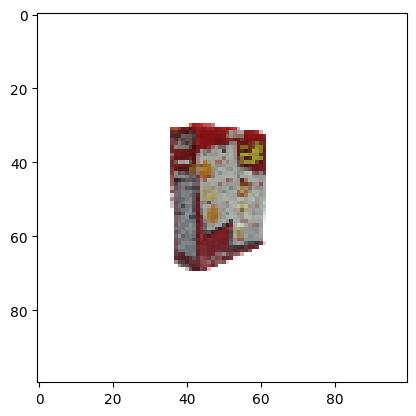

In [ ]:
plt.imshow(get_image(camera))

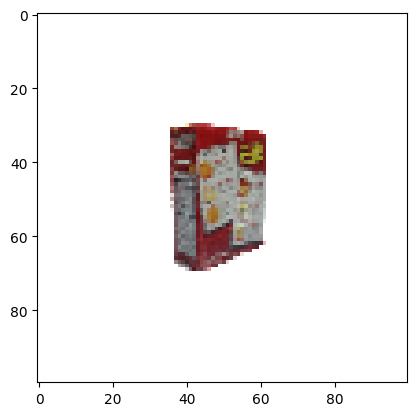

In [ ]:
camera = gen_camera(torch.clone(target_pose).detach(), extra_args['focal'], W, H, z_far)
plt.imshow(get_image(camera))

# (rb.rgb - target_image_flatten[:,:3]).shape, target_mask.sahape

In [ ]:
# loss

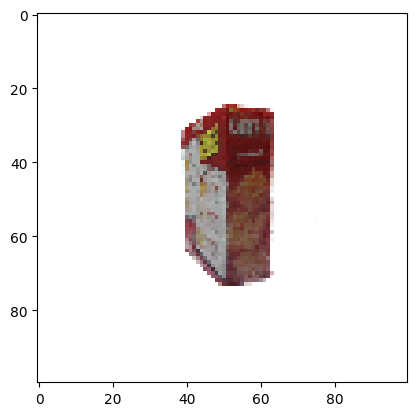

In [ ]:
camera1 = gen_camera(torch.clone(input_pose).detach(), extra_args['focal'], W, H, z_far)
plt.imshow(get_image(camera1))

0
0
0


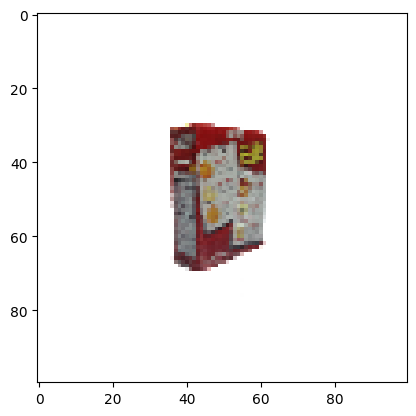

In [ ]:
camera2 = gen_camera(torch.clone(target_pose).detach(), extra_args['focal'], W, H, z_far)
plt.imshow(get_image(camera2))

In [ ]:
# print(np.mean((target_image_np[...,:3]/255. - get_image(camera1)[0])**2))
# print(np.mean((target_image_np[...,:3]/255. - get_image(camera2)[0])**2))

print(np.abs((target_image_np[...,:3]/255. - get_image(camera1))).mean())
print(np.abs((target_image_np[...,:3]/255. - get_image(camera2))).mean())

0.04547553587550687
0.006779358914806722


In [ ]:
im1 = input_image_np[...,:3]
im2 = (255*get_image(camera1)).astype('uint8')
v = cv2.absdiff(im1, im2)
cv2.imwrite('diff.png', v)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

True

In [ ]:
camera1.extrinsics.parameters()

tensor([[ 4.2720e-01,  1.3709e-16, -9.0416e-01,  0.0000e+00, -1.0485e-01,
          9.9325e-01, -4.9538e-02,  2.6880e-01,  8.9806e-01,  1.1596e-01,
          4.2432e-01, -2.6794e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.0000e+00]], device='cuda:0')

In [ ]:
camera1.extrinsics.parameters()

tensor([[ 4.2720e-01,  1.3709e-16, -9.0416e-01,  0.0000e+00, -1.0485e-01,
          9.9325e-01, -4.9538e-02,  2.6880e-01,  8.9806e-01,  1.1596e-01,
          4.2432e-01, -2.6794e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.0000e+00]], device='cuda:0')

In [ ]:
cv2.imwrite('ren.png', cv2.cvtColor(im2, cv2.COLOR_RGB2BGR))
cv2.imwrite('tgt.png', cv2.cvtColor(target_image_np[...,:3], cv2.COLOR_RGB2BGR))

True

In [ ]:
im1.dtype

dtype('uint8')

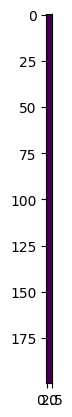

In [ ]:
plt.imshow(get_image(camera2)[0])

In [ ]:
rb.alpha.mean()

tensor(0.3070, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
def loss_fn(gold, cam):
    rgb_pred, alpha_pred = get_image(cam)
    # print(alpha_pred.shape)
    # print(gold)
    rgb_gold, alpha_gold = gold[...,:3]/255, gold[...,3]/255
    # print(alpha_gold.shape)
    # print(np.max(alpha_pred.squeeze()))
    # print(np.max(alpha_gold))
    # print(np.sum(((alpha_pred.squeeze()>0.001).astype(bool) ^ (alpha_gold < 0.001).astype(bool))))
    mask = (alpha_pred.squeeze()>0.001).astype(bool) | (alpha_gold > 0.001).astype(bool)
    plt.figure()
    plt.imshow(mask*255)
    loss = np.mean(((rgb_gold - rgb_pred)[mask])**2)
    return loss
print(loss_fn(target_image_np, camera1))
print(loss_fn(target_image_np, camera2))

ValueError: too many values to unpack (expected 2)

In [ ]:
torch.sum(torch.isnan(rb.rgb)), rb.rgb.shape

(tensor(0, device='cuda:0'), torch.Size([160000, 3]))

In [ ]:
orig_vector = torch.autograd.Variable(torch.tensor([[1.,5.,6.]]).float().cuda(), requires_grad=True)
dir_vector = torch.autograd.Variable(torch.tensor([[2.,3.,1.0]]).float().cuda(), requires_grad=True)
temp_rays = Rays(origins=orig_vector, dirs=dir_vector, dist_max=10.0).to('cuda') 
rgb = pipeline(temp_rays, lod_idx=15, channels=["rgb"]).rgb

In [ ]:
loss = torch.nn.MSELoss()(rgb, torch.tensor([[0.0, 0.0, 0.0]]).cuda())

In [ ]:
loss.backward()

In [ ]:
orig_vector.grad

In [ ]:
cam_pose = torch.clone(input_pose.detach())
n_steps = 1000 + 1
mse_loss = torch.nn.MSELoss()
sampling = 'center'

# Pose optimization.
predicted_poses = []
fine_patches = []
gt_patches = []
idxs_sampled = torch.randint(0, H*W, (n_rays,))

for i_step in range(n_steps):
    optimizer.zero_grad()

    rays = gen_rays(cam_pose, focal, W, H, z_far)
    rays = rays.reshape((rays.shape[0]**2, -1))
    # frac = 0.5
    # mask = torch.zeros((H, W))
    # h_low = int(0.5*(1-frac)*H)
    # h_high = int(0.5*(1+frac)*H)
    # w_low = int(0.5*(1-frac)*W)
    # w_high = int(0.5*(1+frac)*W)
    # mask[h_low:h_high, w_low:w_high] = 1
    # mask = mask.reshape(H*W)
    # idxs_masked = torch.where(mask>0)[0]
    # idxs_sampled = idxs_masked[torch.randint(0, 
    # .shape[0], (n_rays,))]

    rays = rays[idxs_sampled]
    lods = list(range(pipeline.nef.grid.num_lods))
    lod_idx = lods[-1]
    rb = pipeline(rays, lod_idx=lod_idx, channels=["rgb"])
    target_image_flatten_sampled = target_image_flatten[idxs_sampled]

    loss = mse_loss(rb.rgb, target_image_flatten_sampled)

    if i_step % 100 == 0:        
        # predicted_poses.append(torch.clone(cam_pose).detach().numpy())
        # fine_patches.append(torch.clone(rgb).detach().cpu().numpy().reshape(H, W, 3))
        # gt_patches.append(torch.clone(target_image_flatten).detach().cpu().numpy().reshape(H, W, 3))
        print(f"Step {i_step}, loss: {loss}")
    optimizer.step()
    # print(f"Step {i_step}, loss: {loss}, {cam_pose.grad}")

In [ ]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

## Render the results

In [ ]:
def create_image(patch):
    image = np.zeros((128, 128, 3))
    image[48:80, 48:80, :] = patch
    image = (image * 255.0).astype(np.uint8)
    return image

# Rendering.
overlay_frames = []
n_poses = len(predicted_poses)
render_poses = torch.from_numpy(np.array(predicted_poses))
render_rays = util.gen_rays(render_poses, W, H, focal, z_near, z_far).to(device=device)
with torch.no_grad():
    print("Rendering", n_poses * H * W, "rays")
    all_rgb_fine = []
    for rays in tqdm.tqdm(torch.split(render_rays.view(-1, 8), 20000, dim=0)):
        rgb, _depth = render_par(rays[None])
        all_rgb_fine.append(rgb[0])
    _depth = None
    rgb_fine = torch.cat(all_rgb_fine)
    frames = (rgb_fine.view(n_poses, H, W, 3).cpu().numpy() * 255).astype(
        np.uint8
    )
    target_image = (target_image_flatten.cpu().numpy().reshape([H, W, 3]) * 255.0).astype(np.uint8)
    target_images = np.stack([np.array(target_image)]*n_poses, 0)
    
    im_name = os.path.basename(os.path.splitext(config['input'])[0])

    frames_dir_name = os.path.join(config['output'], im_name + "_frames")
    os.makedirs(frames_dir_name, exist_ok=True)

    for i in range(n_poses):
        if sampling == 'patch':
            pred_patch_path = os.path.join(config['output'], f'./pred_patch_{i}.png')
            pred_image = create_image(fine_patches[i])

            gt_patch_path = os.path.join(config['output'], f'./gt_patch_{i}.png')
            gt_image = create_image(gt_patches[i])
            overlay_frame = (pred_image*0.5).astype(np.uint8) + (gt_image*0.5).astype(np.uint8)
        else:
            overlay_frame = (frames[i]*0.5).astype(np.uint8) + (target_images[i]*0.5).astype(np.uint8)
        overlay_frames.append(overlay_frame)

NameError: name 'util' is not defined

## Visualize the results

We show the overlay of the image rendered with our predicted pose and the target image.

Step 0,Step 10,Step 20,Step 30,Step 40,Step 50,Step 60,Step 70,Step 80,Step 90,Step 100

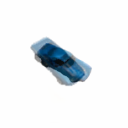
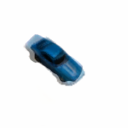
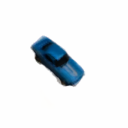
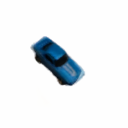
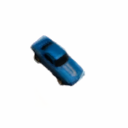
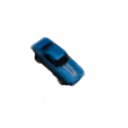
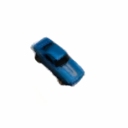
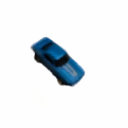
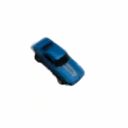
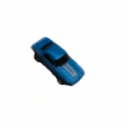
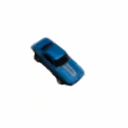

In [ ]:
data = {}
for i, f in enumerate(overlay_frames):
    step = i*10
    data[f"Step {step}"] = f
media.show_images(data)

In [ ]:
import torch
import torch.optim as optim

# Step 1: Define the quadratic function
def quadratic(x):
    return x**2 - 4*x + 4

# Step 2: Create a PyTorch Variable
x = torch.autograd.Variable(torch.tensor(0.0), requires_grad=True)

# Step 3: Define the loss function
def loss_function(y):
    return y**2

# Step 4: Initialize the Adam optimizer
optimizer = optim.Adam([x], lr=0.1)



In [ ]:
x.grad

In [ ]:
y = quadratic(x)  # Compute the function value
loss = loss_function(y)  # Compute the loss
optimizer.zero_grad()  # Clear gradients from previous step
# loss.backward()  # Compute gradients
# optimizer.step()  # Update variable using Adam optimizer


In [ ]:
loss.backward()

In [ ]:
loss.grad

/home/optimus/miniconda3/envs/wisp/lib/python3.9/site-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:477.)
  return self._grad


In [ ]:
x.grad, x.data

(tensor(-32.), tensor(0.))

In [ ]:
# Step 5: Gradient descent loop
for _ in range(1000):  # You can adjust the number of iterations
  y = quadratic(x)  # Compute the function value
  loss = loss_function(y)  # Compute the loss
  optimizer.zero_grad()  # Clear gradients from previous step
  loss.backward()  # Compute gradients
  optimizer.step()  # Update variable using Adam optimizer

# After optimization, x should be close to the zero of the quadratic
print("Optimal x:", x.item())
print("Quadratic value at optimal x:", quadratic(x).item())


In [ ]:
x.data

tensor(1.9519)

torch.float32 torch.float32


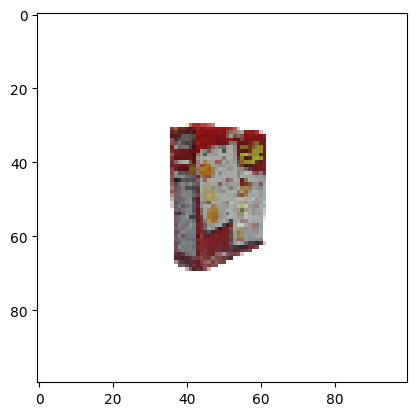

In [48]:
# plt.imshow(get_scipy_image(get_se3_pose(get_pose_6d(cvt_pose_se3(target_pose)))))
plt.imshow(get_scipy_image(cvt_pose_se3(target_pose)))